## Todo: 

- Add to the viz package so that you can include the image path and the image is shown in the picture and the camera is like a box with a direcection
- Investigate why the DLT works pretty well but the RANSAC fails horribly...

In [1]:
from utils.get_dataset_info import get_dataset_info
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from utils.get_dataset_info import get_dataset_info
import cv2 as cv
import numpy as np
from utils import general, pflat, estimate_T_robust, levenberg_marquardt, triangulate_3D_point_DLT, viz
from romatch import roma_outdoor
import torch
import os
from tqdm import tqdm
import utils.viz

K, img_names, init_pair, pixel_threshold = get_dataset_info(2)
K_inv = np.linalg.inv(K)
image_paths = ['./project_data/'+img_name for img_name in img_names]

In [2]:
 # Normalize pixel threshold
focal_length = (K[0,0] + K[1 ,1])/2 # Average over the diagonal
epipolar_treshold =          pixel_threshold / focal_length
homography_threshold =   3 * pixel_threshold / focal_length
translation_threshold  = 3 * pixel_threshold / focal_length

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
roma_model = roma_outdoor(device=device)

/home/davnords/python-envs/main/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/davnords/python-envs/main/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Using coarse resolution (560, 560), and upsample res (864, 864)


In [4]:
relative_rotations = general.find_relative_rotation(image_paths, K_inv, roma_model, epipolar_treshold, device=device)

RANSAC iterations: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.72it/s]


After running RANSAC for 100 iterations the best solution has 1686 inliers of 10000 points. I.e. c. 16.86%


RANSAC iterations: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.69it/s]


After running RANSAC for 100 iterations the best solution has 2651 inliers of 10000 points. I.e. c. 26.51%


RANSAC iterations: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.60it/s]


After running RANSAC for 100 iterations the best solution has 6671 inliers of 10000 points. I.e. c. 66.71%


RANSAC iterations: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.82it/s]


After running RANSAC for 100 iterations the best solution has 8692 inliers of 10000 points. I.e. c. 86.92%


RANSAC iterations: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.79it/s]


After running RANSAC for 100 iterations the best solution has 5386 inliers of 10000 points. I.e. c. 53.86%


RANSAC iterations: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.87it/s]


After running RANSAC for 100 iterations the best solution has 9993 inliers of 10000 points. I.e. c. 99.93%


RANSAC iterations: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.81it/s]


After running RANSAC for 100 iterations the best solution has 9787 inliers of 10000 points. I.e. c. 97.87%


RANSAC iterations: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.78it/s]

After running RANSAC for 100 iterations the best solution has 9970 inliers of 10000 points. I.e. c. 99.70%


In [5]:
absolute_rotations = general.upgrade_to_absolute_rotation(relative_rotations)

In [6]:
from utils.estimate_camera_DLT import estimate_camera_DLT
imA_path = image_paths[init_pair[0]-1]
Ps = []
xs = []
for i in range(len(image_paths)):
    R = absolute_rotations[i]
    if i == init_pair[0]-1:
        print('Skipping...')
        T=np.zeros((3,1))
        Ps.append(np.hstack((R, T)))
    else:
        x1u, x2u = general.find_matches(imA_path, image_paths[i], roma_model, device=device)
        x1n = pflat.pflat(K_inv @ x1u)
        x2n = pflat.pflat(K_inv @ x2u)
        X = general.triangulate_initial_points(x1n, x2n, epipolar_treshold)
        X = (absolute_rotations[init_pair[0]-1]).T@X.T
        Ps.append(estimate_T_robust.estimate_T_robust(x2n, general.make_homogenous(X.T), R, translation_threshold, iterations=10))
        xs.append(x2n)

Skipping...


RANSAC iterations: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.68it/s]


After running RANSAC for 100 iterations the best solution has 2511 inliers of 10000 points. I.e. c. 25.11%


RANSAC iterations: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 3894.07it/s]


After running RANSAC for 10 iterations the best solution has 10000 inliers of 10000 points. I.e. c. 100.00%


RANSAC iterations: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.35it/s]


After running RANSAC for 100 iterations the best solution has 7030 inliers of 10000 points. I.e. c. 70.30%


RANSAC iterations: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 3349.82it/s]


After running RANSAC for 10 iterations the best solution has 10000 inliers of 10000 points. I.e. c. 100.00%


RANSAC iterations: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.61it/s]


After running RANSAC for 100 iterations the best solution has 9268 inliers of 10000 points. I.e. c. 92.68%


RANSAC iterations: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 3818.21it/s]


After running RANSAC for 10 iterations the best solution has 10000 inliers of 10000 points. I.e. c. 100.00%


RANSAC iterations: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.57it/s]


After running RANSAC for 100 iterations the best solution has 5670 inliers of 10000 points. I.e. c. 56.70%


RANSAC iterations: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 3873.57it/s]


After running RANSAC for 10 iterations the best solution has 10000 inliers of 10000 points. I.e. c. 100.00%


RANSAC iterations: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.64it/s]


After running RANSAC for 100 iterations the best solution has 4110 inliers of 10000 points. I.e. c. 41.10%


RANSAC iterations: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 3794.03it/s]


After running RANSAC for 10 iterations the best solution has 10000 inliers of 10000 points. I.e. c. 100.00%


RANSAC iterations: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.52it/s]


After running RANSAC for 100 iterations the best solution has 4792 inliers of 10000 points. I.e. c. 47.92%


RANSAC iterations: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 3778.31it/s]


After running RANSAC for 10 iterations the best solution has 10000 inliers of 10000 points. I.e. c. 100.00%


RANSAC iterations: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.61it/s]


After running RANSAC for 100 iterations the best solution has 4762 inliers of 10000 points. I.e. c. 47.62%


RANSAC iterations: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 3953.53it/s]


After running RANSAC for 10 iterations the best solution has 10000 inliers of 10000 points. I.e. c. 100.00%


RANSAC iterations: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.65it/s]


After running RANSAC for 100 iterations the best solution has 5352 inliers of 10000 points. I.e. c. 53.52%


RANSAC iterations: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 3466.94it/s]

After running RANSAC for 10 iterations the best solution has 10000 inliers of 10000 points. I.e. c. 100.00%


In [13]:
imA_path = image_paths[init_pair[0]-1]
imB_path = image_paths[init_pair[1]-1]

x1u, x2u = general.find_matches(imA_path, imB_path, roma_model, device=device)

x1n = pflat.pflat(K_inv @ x1u)
x2n = pflat.pflat(K_inv @ x2u)

X = general.triangulate_initial_points(x1n, x2n, epipolar_treshold)
X = (absolute_rotations[init_pair[0]-1]).T@X.T

RANSAC iterations: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.78it/s]


After running RANSAC for 100 iterations the best solution has 5506 inliers of 10000 points. I.e. c. 55.06%


Triangulating points...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.09it/s]


In [11]:
from utils.plotcams import plotcams
def plot_scene_old(Xs, Ps, title='Scene reconstruction SfM', name='scene_reconstruction.png'):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(Xs[:, 0], Xs[:, 1], Xs[:, 2], 'bo', alpha=0.2, markersize=0.5)
    plotcams(Ps, ax=ax, scale=0.1)
    plt.axis('equal')
    plt.title(title)
    plt.savefig(f"plots/{name}")
    plt.show()

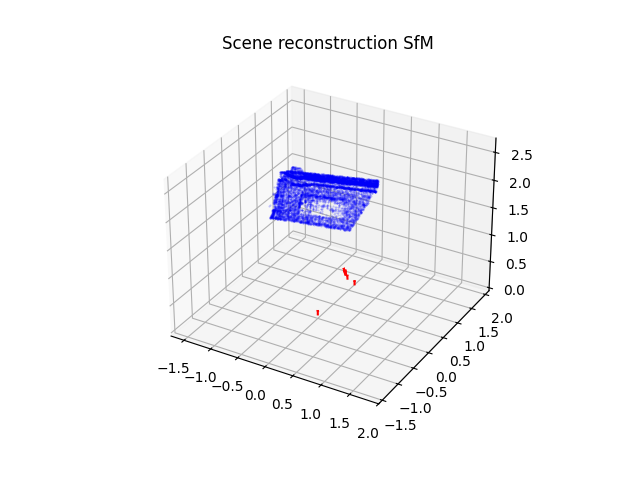

In [14]:
%matplotlib widget

plot_scene_old(X.T, Ps)

In [452]:
Ps = run_bundle_adjustment(X, xs, Ps, mu=100000000)

Performing Bundle Adjustment...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 286.52it/s]

Full reprojection error in epoch 1/5 is: 5676.4045
Full reprojection error in epoch 2/5 is: 5676.4045
Full reprojection error in epoch 3/5 is: 5676.4045
Full reprojection error in epoch 4/5 is: 5676.4045
Full reprojection error in epoch 5/5 is: 5676.4045


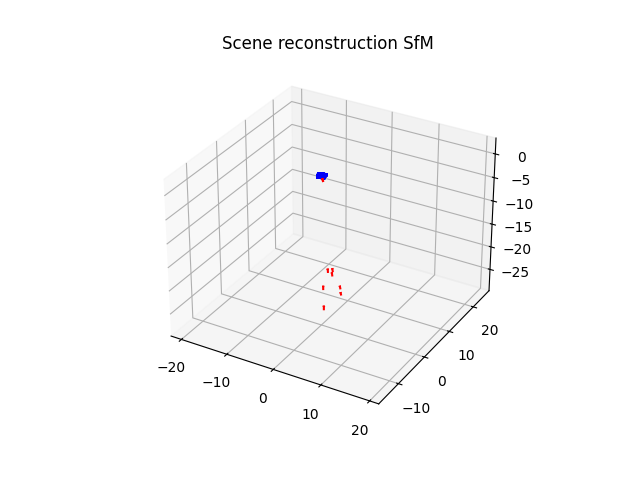

In [453]:
%matplotlib widget
plot_scene_old(X.T, Ps)